## Курсовое практическое задание по теме "Введение в нейронные сети".

*Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети*

Для задания возьмём датасет cifar100 со 100 классами. Для решения задачи  
воспользуемся transfer learning и в качестве модели будем использовать  
предобученную модель MobileNet без последнего слоя. Обучим последний  
слой и посмотрим результат. Сделаем выводы о проделанной работе.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

Загрузим датасет:

In [3]:
splits = ['train', 'test']

(training_set, validation_set), dataset_info = tfds.load(
    'cifar100',
    split=splits,
    with_info=True,
    as_supervised=True
)

Убедимся в размерах выборок и количестве классов:

In [4]:
print('Число классов:', dataset_info.features['label'].num_classes)
print('Число изображений в обучающей выборке:', len(training_set))
print('Число изображений в тестовой выборке:', len(validation_set))

Число классов: 100
Число изображений в обучающей выборке: 50000
Число изображений в тестовой выборке: 10000


Посмотрим на размер картинок в нашем датасете:

In [5]:
next(iter(training_set.take(1)))[0].shape

2022-08-15 15:02:53.502412: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TensorShape([32, 32, 3])

Подготовим датасеты для модели. Так как MobileNet принимает на вход  
изображения размером 224х224, то увеличим наши картинки 32х32 до этого  
размера. Сделаем нормализацию и разбивку на батчи:

In [6]:
IMAGE_RES = 224
BATCH_SIZE = 32
RANDOM_STATE = 29

def preprocess_img(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    return image, label


tf.random.set_seed(RANDOM_STATE)
train_batches = training_set.shuffle(len(training_set)).map(preprocess_img).batch(BATCH_SIZE).prefetch(1)
val_batches = validation_set.map(preprocess_img).batch(BATCH_SIZE).prefetch(1)

Загрузим MobileNet из Tensorflow хаба:

In [7]:
URL = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5'
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

Инициализируем нейронную сеть. В качестве последнего слоя будет  
полносвязный слой со 100 нейронами для классификации на 100 классов:

In [8]:
model = tf.keras.models.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(100, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4226432   
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
Total params: 4,354,532
Trainable params: 128,100
Non-trainable params: 4,226,432
_________________________________________________________________


Веса предобученной MobileNet оставим без изменений. Обучать будем  
только последний слой:

In [9]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4))

In [10]:
EPOCHS = 5

tf.random.set_seed(RANDOM_STATE)

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=val_batches)

Epoch 1/5


2022-08-15 15:03:06.880958: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-15 15:03:07.276032: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1563/1563 [==============================] - 46s 26ms/step - loss: 1.4882 - accuracy: 0.6137 - val_loss: 1.0790 - val_accuracy: 0.6954
Epoch 2/5
1563/1563 [==============================] - 41s 26ms/step - loss: 0.9012 - accuracy: 0.7382 - val_loss: 0.9944 - val_accuracy: 0.7106
Epoch 3/5
1563/1563 [==============================] - 41s 26ms/step - loss: 0.7633 - accuracy: 0.7747 - val_loss: 0.9631 - val_accuracy: 0.7178
Epoch 4/5
1563/1563 [==============================] - 41s 26ms/step - loss: 0.6703 - accuracy: 0.8037 - val_loss: 0.9519 - val_accuracy: 0.7238
Epoch 5/5
1563/1563 [==============================] - 41s 26ms/step - loss: 0.5990 - accuracy: 0.8239 - val_loss: 0.9587 - val_accuracy: 0.7226


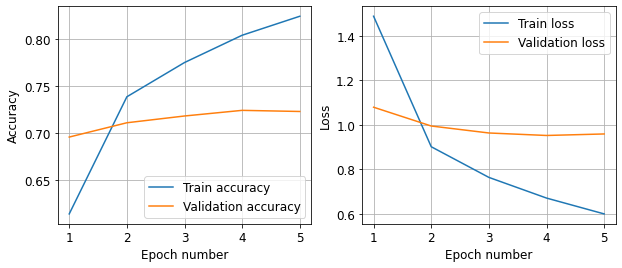

In [11]:
plt.figure(figsize=(10, 4))
plt.rcParams.update({'font.size': 12})

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), history.history['accuracy'], label='Train accuracy')
plt.plot(range(1, EPOCHS+1), history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), history.history['loss'], label='Train loss')
plt.plot(range(1, EPOCHS+1), history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

Количество эпох будем считать достаточным. Ошибка на валидационном  
датасете "зависла" на одном значении. После двух эпох появилось  
небольшое переобучение.

Сделаем графическое отображение результатов работы модели:

In [12]:
class_names = dataset_info.features['label'].names

In [13]:
predictions = model.predict(val_batches)

313/313 [==============================] - 7s 21ms/step


In [14]:
def plot_image(prediction_array, true_label, img):

    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

    predicted_label = np.argmax(prediction_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% \n({})".format(class_names[predicted_label],
                                100*np.max(prediction_array),
                                class_names[true_label]),
                                color=color)

In [15]:
def plot_value_array(prediction_array, true_label):
    
    classes = np.array(class_names)
    sorted_preds = np.argsort(prediction_array)[::-1][:10]
    
    plt.xticks(range(10), classes[sorted_preds], rotation=90)
    plt.yticks([])
    plot = plt.bar(range(10), sorted(prediction_array, reverse=True)[:10], color="#777777")
    plt.ylim([0, 1])
    
    plot[0].set_color('red')
    
    if true_label in sorted_preds:
        true_idx = np.where(sorted_preds == true_label)[0][0]
        plot[true_idx].set_color('blue')

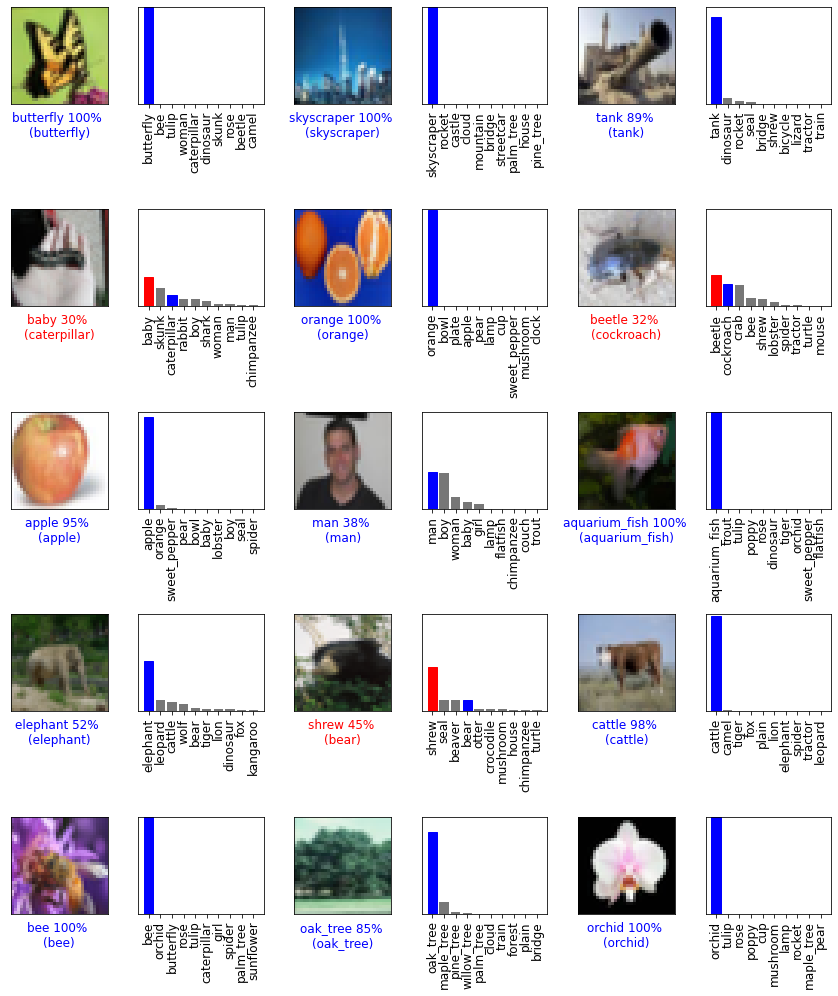

In [16]:
PAGE = 2

num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
val_iterator = iter(validation_set.take(num_images * PAGE))

for _ in range(num_images * (PAGE-1)):
    next(val_iterator)

idx = num_images * (PAGE-1)

plt.figure(figsize=(2*2*num_cols, 2*1.4*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    img, true_label = next(val_iterator)
    plot_image(predictions[idx + i], true_label.numpy(), img.numpy())
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(predictions[idx + i], true_label.numpy())
    
plt.tight_layout()
plt.show()

<ins>Вывод:</ins>  
Воспользовались методом transfer learning для обучения классификатора  
изображений на 100 классов. Получили точность около 72%, что не так  
уж и плохо, учитывая количество классов. Предобученная модель MobileNet  
позволила добиться такого результата при сравнительно недолгом обучении -  
на каждую эпоху было затрачено менее минуты. Сделали отображение результатов  
работы модели.